## **Librerías y módulos necesarios**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.svm import SVR
import statsmodels.api as sm
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from skopt.space import Integer, Categorical, Real
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV

## **Base de datos y métodos útiles**

In [2]:
data = pd.read_csv("C:/Users/valcd/OneDrive/Escritorio/dataparcial2.csv")
data

,hora,direccionviento,velocidadviento,humedadmaxima,humedadminima,temperaturamaxima,temperaturaminima,precipitaciontotal,rafagamaxima,presion_atm_maxima,presion_atm_minima
0,12:00,0.809017,1.8,69.0,60.0,22.6,20.7,0.0,3.8,888.2,887.7
1,13:00,0.965926,2.7,62.0,55.0,24.2,22.5,0.0,4.7,888.4,888.2
2,14:00,0.891007,2.0,56.0,50.0,25.5,24.3,0.0,4.9,888.4,888.1
3,15:00,0.848048,2.5,52.0,44.0,27.4,25.0,0.0,5.8,888.1,887.4
4,16:00,0.224951,2.4,50.0,43.0,27.1,25.5,0.0,5.8,887.4,886.5
...,...,...,...,...,...,...,...,...,...,...,...
87688,19:00,-0.615661,5.6,83.0,78.0,21.8,21.1,0.0,12.3,879.8,879.1
87689,20:00,-0.469472,4.9,84.0,79.0,21.7,21.0,0.0,9.9,879.2,878.9
87690,21:00,-0.484810,4.5,86.0,82.0,21.2,20.6,0.0,8.9,879.8,879.2
87691,22:00,-0.484810,3.2,88.0,85.0,20.6,20.2,0.0,8.0,880.5,879.6


In [3]:
X = data.drop(columns=['hora','velocidadviento']) # Se toman todas las columnas excepto la objetivo
y = data['velocidadviento'] # Se toma solo la columna objetivo

In [4]:
def errorporc(actual, predicho):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicho[j]) / actual[j]
        else:
            res[j] = predicho[j] / np.mean(actual)
    return res

def MAPE(y_true, y_pred): 
    return np.mean(np.abs(errorporc(np.asarray(y_true), np.asarray(y_pred))))*100

# Método para calcular los residuos del modelo

def residuos(y_test, y_prediccion):
    residuo = y_test - y_prediccion
    ljung = acorr_ljungbox(residuo, lags=[10], return_df=True)['lb_pvalue'].values[0]
    jarque = jarque_bera(residuo)  
    jarque = jarque[1]
    return ljung, jarque

## **MODELOS**

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

### **KNN**

In [6]:
knn = KNeighborsRegressor()

knn_paramgrid = {"n_neighbors": (3, 50),"p": (1, 2)}

knn_bayessearch = BayesSearchCV(estimator=knn, search_spaces=knn_paramgrid,n_iter=30,cv=5,random_state=21,verbose=0)

knn_bayessearch.fit(X_train, y_train)

bestknn = knn_bayessearch.best_estimator_
ypredknn = bestknn.predict(X_test)

mseknn = mean_squared_error(y_test, ypredknn)
rmseknn = np.sqrt(mseknn)
mapeknn =MAPE(y_test,ypredknn)
maeknn = mean_absolute_error(y_test, ypredknn)
r2knn = r2_score(y_test, ypredknn)
ljungboxknn, jarqueberaknn = residuos(y_test, ypredknn) 
bestparamsknn = knn_bayessearch.best_params_

In [7]:
valoresknn = {'Modelo': ['KNN'],'MSE': [mseknn],'RMSE': [rmseknn],'MAPE': [mapeknn],'MAE': [maeknn],'R2': [r2knn],'Ljung-Box p-value': [ljungboxknn],'Jarque-Bera p-value': [jarqueberaknn],'Hiperparámetros': [bestparamsknn]}
cuadro1 = pd.DataFrame(valoresknn)
cuadro1

,Modelo,MSE,RMSE,MAPE,MAE,R2,Ljung-Box p-value,Jarque-Bera p-value,Hiperparámetros
0,KNN,0.418614,0.647003,35.56147,0.497178,0.757206,0.223981,0.0,"{'n_neighbors': 14, 'p': 2}"


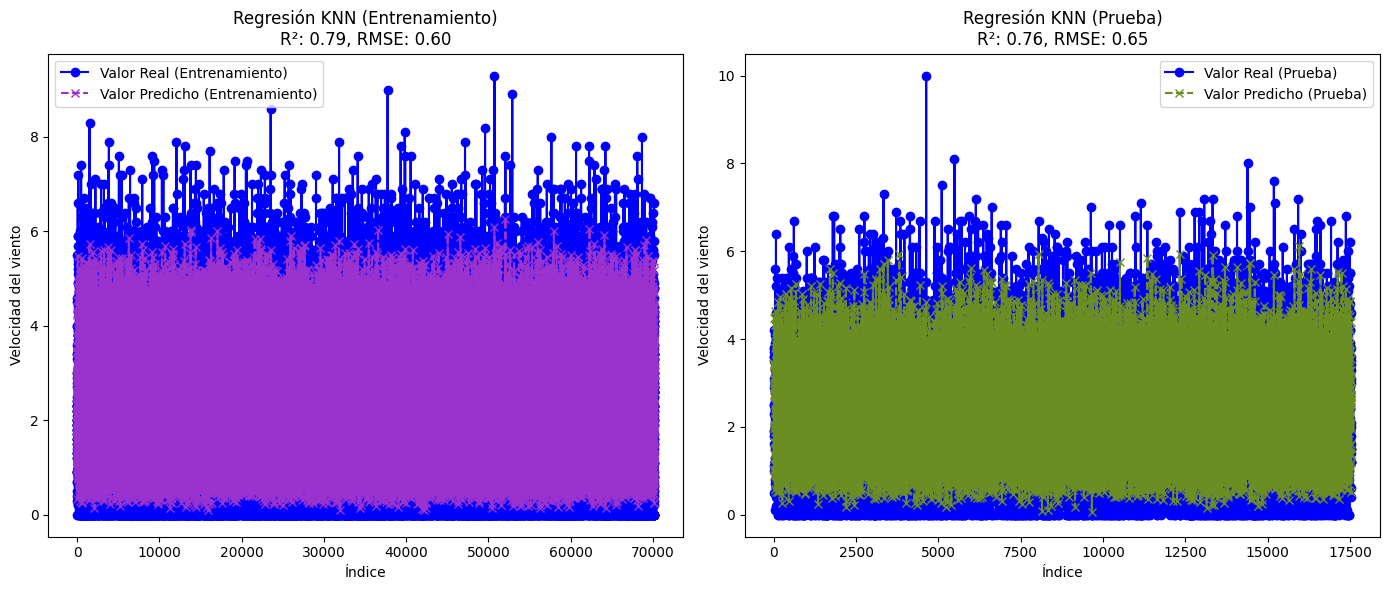

In [8]:
plt.figure(figsize=(14, 6))

ypredtrainknn = bestknn.predict(X_train)
rmsetrainknn = mean_squared_error(y_train, ypredtrainknn, squared=False)
mapetrainknn = MAPE(y_train, ypredtrainknn)
r2trainknn = r2_score(y_train, ypredtrainknn)

# Gráfico para el conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(range(len(y_train)), y_train, label="Valor Real (Entrenamiento)", color='blue', linestyle='-', marker='o')
plt.plot(range(len(ypredtrainknn)), ypredtrainknn, label="Valor Predicho (Entrenamiento)", color='#9A32CD', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"Regresión KNN (Entrenamiento)\nR²: {r2trainknn:.2f}, RMSE: {rmsetrainknn:.2f}")
plt.legend()

# Gráfico para el conjunto de prueba
plt.subplot(1, 2, 2)
plt.plot(range(len(y_test)), y_test, label="Valor Real (Prueba)", color='blue', linestyle='-', marker='o')
plt.plot(range(len(ypredknn)), ypredknn, label="Valor Predicho (Prueba)", color='#6B8E23', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"Regresión KNN (Prueba)\nR²: {r2knn:.2f}, RMSE: {rmseknn:.2f}")
plt.legend()

# Mostrar gráfico
plt.tight_layout()
plt.show()

In [9]:
import pickle
with open("C:/Users/valcd/OneDrive/Escritorio/MachinelearningUN/knndata.pkl", 'wb') as f:
    pickle.dump(bestknn, f)
    pickle.dump(y_train, f)
    pickle.dump(ypredtrainknn, f)
    pickle.dump(y_test, f)
    pickle.dump(ypredknn, f)
    pickle.dump(cuadro1, f)

### **RIDGE**

In [10]:
ridge = Ridge()

ridge_paramgrid = {"alpha": (0.01, 10.0), "solver": ["auto", "svd", "cholesky", "lsqr", "saga"]}

ridge_bayessearch = BayesSearchCV(estimator=ridge, search_spaces=ridge_paramgrid, n_iter=30, cv=5, random_state=21, verbose=0)

ridge_bayessearch.fit(X_train, y_train)

bestridge = ridge_bayessearch.best_estimator_

ypredridge = bestridge.predict(X_test)

mseridge = mean_squared_error(y_test, ypredridge)
rmseridge = np.sqrt(mseridge)
maperidge = MAPE(y_test, ypredridge)
maeridge = mean_absolute_error(y_test, ypredridge)
r2ridge = r2_score(y_test, ypredridge)
ljungboxridge, jarqueberaridge = residuos(y_test, ypredridge)
bestparamsridge = ridge_bayessearch.best_params_

In [12]:
valoresridge = {'Modelo': ['RIDGE'],'MSE': [mseridge],'RMSE': [rmseridge],'MAPE': [maperidge],'MAE': [maeridge],'R2': [r2ridge],'Ljung-Box p-value': [ljungboxridge],'Jarque-Bera p-value': [jarqueberaridge],'Hiperparámetros': [bestparamsridge]}
cuadro2 = pd.DataFrame(valoresridge)
cuadro2

,Modelo,MSE,RMSE,MAPE,MAE,R2,Ljung-Box p-value,Jarque-Bera p-value,Hiperparámetros
0,RIDGE,0.375792,0.613019,32.344499,0.460759,0.782043,0.539328,0.0,"{'alpha': 5.475399576907988, 'solver': 'saga'}"


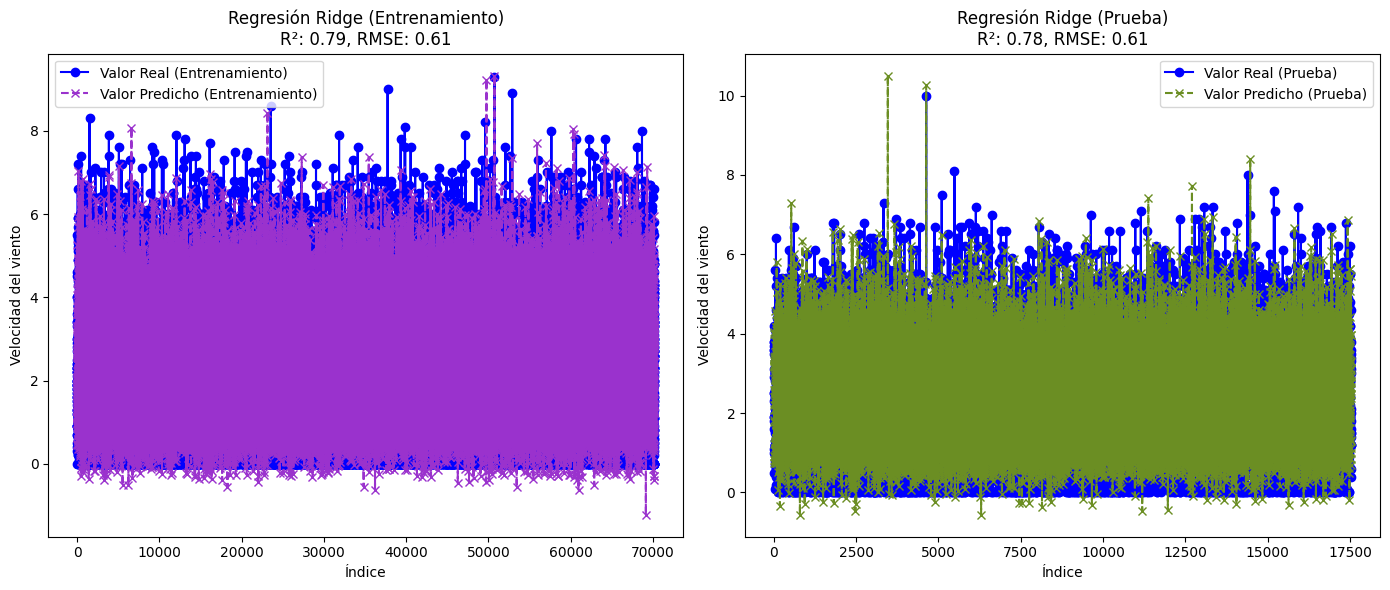

In [13]:
plt.figure(figsize=(14, 6))

ypredtrainridge = bestridge.predict(X_train)
rmsetrainridge = mean_squared_error(y_train, ypredtrainridge, squared=False)
mapetrainridge = MAPE(y_train, ypredtrainridge)
r2trainridge = r2_score(y_train, ypredtrainridge)

# Gráfico para el conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(range(len(y_train)), y_train, label="Valor Real (Entrenamiento)", color='blue', linestyle='-', marker='o')
plt.plot(range(len(ypredtrainridge)), ypredtrainridge, label="Valor Predicho (Entrenamiento)", color='#9A32CD', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"Regresión Ridge (Entrenamiento)\nR²: {r2trainridge:.2f}, RMSE: {rmsetrainridge:.2f}")
plt.legend()

# Gráfico para el conjunto de prueba
plt.subplot(1, 2, 2)
plt.plot(range(len(y_test)), y_test, label="Valor Real (Prueba)", color='blue', linestyle='-', marker='o')
plt.plot(range(len(ypredridge)), ypredridge, label="Valor Predicho (Prueba)", color='#6B8E23', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"Regresión Ridge (Prueba)\nR²: {r2ridge:.2f}, RMSE: {rmseridge:.2f}")
plt.legend()

# Mostrar gráfico
plt.tight_layout()
plt.show()

In [14]:
import pickle
with open("C:/Users/valcd/OneDrive/Escritorio/MachinelearningUN/ridgedata.pkl", 'wb') as f:
    pickle.dump(bestridge, f)
    pickle.dump(y_train, f)
    pickle.dump(ypredtrainridge, f)
    pickle.dump(y_test, f)
    pickle.dump(ypredridge, f)
    pickle.dump(cuadro2, f)

### **LASSO**

In [15]:
lasso = Lasso()

lasso_paramgrid = {"alpha": (0.01, 10.0), "max_iter": (1000, 2000), "tol": (1e-4, 1e-3)}

lasso_bayessearch = BayesSearchCV(estimator=lasso, search_spaces=lasso_paramgrid, n_iter=30, cv=5, random_state=21, verbose=0)

lasso_bayessearch.fit(X_train, y_train)

bestlasso = lasso_bayessearch.best_estimator_

ypredlasso = bestlasso.predict(X_test)

mselasso = mean_squared_error(y_test, ypredlasso)
rmselasso = np.sqrt(mselasso)
mapelasso = MAPE(y_test, ypredlasso)
maelasso = mean_absolute_error(y_test, ypredlasso)
r2lasso = r2_score(y_test, ypredlasso)
ljungboxlasso, jarqueberalasso = residuos(y_test, ypredlasso)
bestparamslasso = lasso_bayessearch.best_params_

In [16]:
valoreslasso = {'Modelo': ['LASSO'],'MSE': [mselasso],'RMSE': [rmselasso],'MAPE': [mapelasso],'MAE': [maelasso],'R2': [r2lasso],'Ljung-Box p-value': [ljungboxlasso],'Jarque-Bera p-value': [jarqueberalasso],'Hiperparámetros': [bestparamslasso]}
cuadro3 = pd.DataFrame(valoreslasso)
cuadro3

,Modelo,MSE,RMSE,MAPE,MAE,R2,Ljung-Box p-value,Jarque-Bera p-value,Hiperparámetros
0,LASSO,0.37644,0.613547,32.522367,0.461593,0.781667,0.555021,0.0,"{'alpha': 0.01, 'max_iter': 2000, 'tol': 0.0001}"


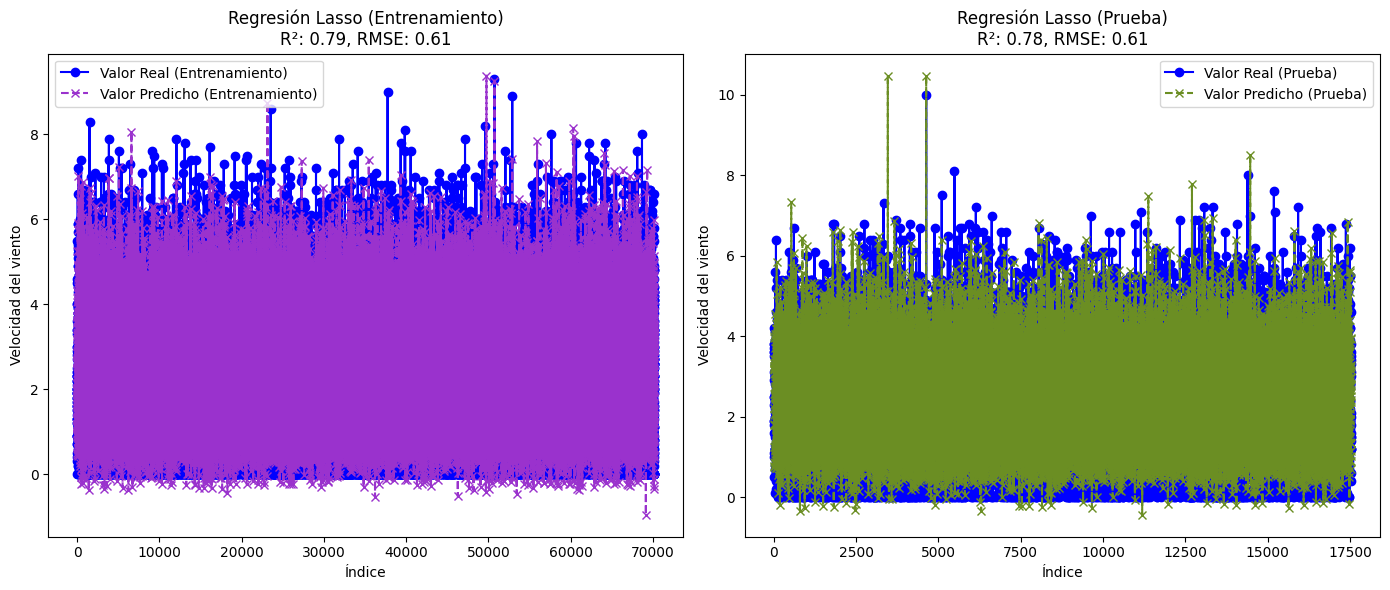

In [17]:
plt.figure(figsize=(14, 6))

ypredtrainlasso = bestlasso.predict(X_train)
rmsetrainlasso = mean_squared_error(y_train, ypredtrainlasso, squared=False)
mapetrainlasso = MAPE(y_train, ypredtrainlasso)
r2trainlasso = r2_score(y_train, ypredtrainlasso)

# Gráfico para el conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(range(len(y_train)), y_train, label="Valor Real (Entrenamiento)", color='blue', linestyle='-', marker='o')
plt.plot(range(len(ypredtrainlasso)), ypredtrainlasso, label="Valor Predicho (Entrenamiento)", color='#9A32CD', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"Regresión Lasso (Entrenamiento)\nR²: {r2trainlasso:.2f}, RMSE: {rmsetrainlasso:.2f}")
plt.legend()

# Gráfico para el conjunto de prueba
plt.subplot(1, 2, 2)
plt.plot(range(len(y_test)), y_test, label="Valor Real (Prueba)", color='blue', linestyle='-', marker='o')
plt.plot(range(len(ypredlasso)), ypredlasso, label="Valor Predicho (Prueba)", color='#6B8E23', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"Regresión Lasso (Prueba)\nR²: {r2lasso:.2f}, RMSE: {rmselasso:.2f}")
plt.legend()

# Mostrar gráfico
plt.tight_layout()
plt.show()

In [18]:
import pickle
with open("C:/Users/valcd/OneDrive/Escritorio/MachinelearningUN/lassodata.pkl", 'wb') as f:
    pickle.dump(bestlasso, f)
    pickle.dump(y_train, f)
    pickle.dump(ypredtrainlasso, f)
    pickle.dump(y_test, f)
    pickle.dump(ypredlasso, f)
    pickle.dump(cuadro3, f)

### **DECISION TREE**

In [19]:
dectree = DecisionTreeRegressor()

dectree_paramgrid = {'max_depth': Integer(1, 20), 'min_samples_split': Integer(2, 20), 'min_samples_leaf': Integer(1, 20)}

dectree_bayessearch = BayesSearchCV(estimator=dectree, search_spaces=dectree_paramgrid, n_iter=30, cv=5, random_state=21, verbose=0)

dectree_bayessearch.fit(X_train, y_train)

bestdectree = dectree_bayessearch.best_estimator_

ypreddectree = bestdectree.predict(X_test)

msedectree = mean_squared_error(y_test, ypreddectree)
rmsedectree = np.sqrt(msedectree)
mapedectree = MAPE(y_test, ypreddectree)
maedectree = mean_absolute_error(y_test, ypreddectree)
r2dectree = r2_score(y_test, ypreddectree)
ljungboxdectree, jarqueberadectree = residuos(y_test, ypreddectree)
bestparamsdectree = dectree_bayessearch.best_params_

In [20]:
valoresdectree = {'Modelo': ['DEC. TREE'],'MSE': [msedectree],'RMSE': [rmsedectree],'MAPE': [mapedectree],'MAE': [maedectree],'R2': [r2dectree],'Ljung-Box p-value': [ljungboxdectree],'Jarque-Bera p-value': [jarqueberadectree],'Hiperparámetros': [bestparamsdectree]}
cuadro4 = pd.DataFrame(valoresdectree)
cuadro4

,Modelo,MSE,RMSE,MAPE,MAE,R2,Ljung-Box p-value,Jarque-Bera p-value,Hiperparámetros
0,DEC. TREE,0.352151,0.593423,31.347853,0.448226,0.795754,0.768733,0.0,"{'max_depth': 8, 'min_samples_leaf': 20, 'min_..."


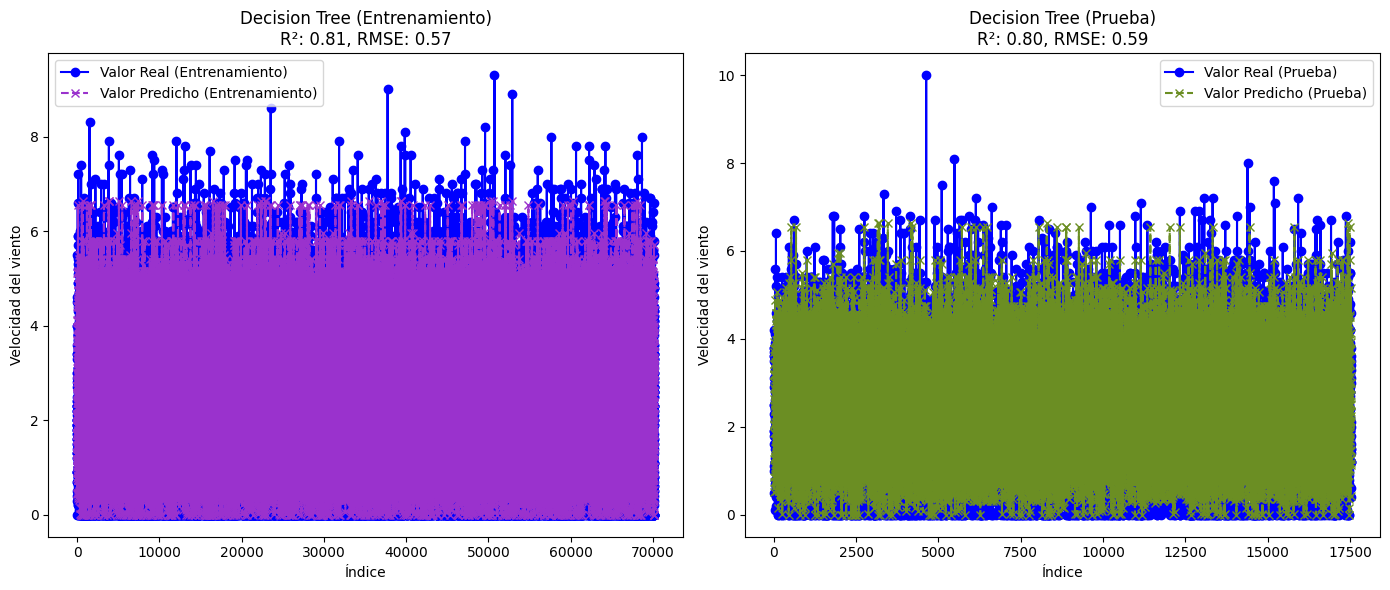

In [21]:
plt.figure(figsize=(14, 6))

ypredtraindectree = bestdectree.predict(X_train)
rmsetraindectree = mean_squared_error(y_train, ypredtraindectree, squared=False)
mapetraindectree = MAPE(y_train, ypredtraindectree)
r2traindectree = r2_score(y_train, ypredtraindectree)

# Gráfico para el conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(range(len(y_train)), y_train, label="Valor Real (Entrenamiento)", color='blue', linestyle='-', marker='o')
plt.plot(range(len(ypredtraindectree)), ypredtraindectree, label="Valor Predicho (Entrenamiento)", color='#9A32CD', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"Decision Tree (Entrenamiento)\nR²: {r2traindectree:.2f}, RMSE: {rmsetraindectree:.2f}")
plt.legend()

# Gráfico para el conjunto de prueba
plt.subplot(1, 2, 2)
plt.plot(range(len(y_test)), y_test, label="Valor Real (Prueba)", color='blue', linestyle='-', marker='o')
plt.plot(range(len(ypreddectree)), ypreddectree, label="Valor Predicho (Prueba)", color='#6B8E23', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"Decision Tree (Prueba)\nR²: {r2dectree:.2f}, RMSE: {rmsedectree:.2f}")
plt.legend()

# Mostrar gráfico
plt.tight_layout()
plt.show()

In [22]:
import pickle
with open("C:/Users/valcd/OneDrive/Escritorio/MachinelearningUN/dectreedata.pkl", 'wb') as f:
    pickle.dump(bestdectree, f)
    pickle.dump(y_train, f)
    pickle.dump(ypredtraindectree, f)
    pickle.dump(y_test, f)
    pickle.dump(ypreddectree, f)
    pickle.dump(cuadro4, f)

### **RANDOM FOREST**

In [23]:
ranfor = RandomForestRegressor(random_state=21)

ranfor_paramgrid = {'n_estimators': Integer(10, 100), 'max_depth': Integer(5, 20)}

ranfor_bayessearch = BayesSearchCV(estimator=ranfor,search_spaces=ranfor_paramgrid,n_iter=20,cv=5,random_state=21,verbose=0,n_jobs=-1)

ranfor_bayessearch.fit(X_train, y_train)

bestranfor = ranfor_bayessearch.best_estimator_

ypredranfor = bestranfor.predict(X_test)

mseranfor = mean_squared_error(y_test, ypredranfor)
rmseranfor = np.sqrt(mseranfor)
maperanfor = MAPE(y_test, ypredranfor)
maeranfor = mean_absolute_error(y_test, ypredranfor)
r2ranfor = r2_score(y_test, ypredranfor)
ljungboxranfor, jarquebreranfor = residuos(y_test, ypredranfor)
bestparamsranfor = ranfor_bayessearch.best_params_

In [24]:
valoresranfor = {'Modelo': ['RANDOM FOREST'],'MSE': [mseranfor],'RMSE': [rmseranfor],'MAPE': [maperanfor],'MAE': [maeranfor],'R2': [r2ranfor],'Ljung-Box p-value': [ljungboxranfor],'Jarque-Bera p-value': [jarquebreranfor],'Hiperparámetros': [bestparamsranfor]}
cuadro5 = pd.DataFrame(valoresranfor)
cuadro5

,Modelo,MSE,RMSE,MAPE,MAE,R2,Ljung-Box p-value,Jarque-Bera p-value,Hiperparámetros
0,RANDOM FOREST,0.333588,0.57757,30.750531,0.43665,0.806521,0.766052,0.0,"{'max_depth': 11, 'n_estimators': 82}"


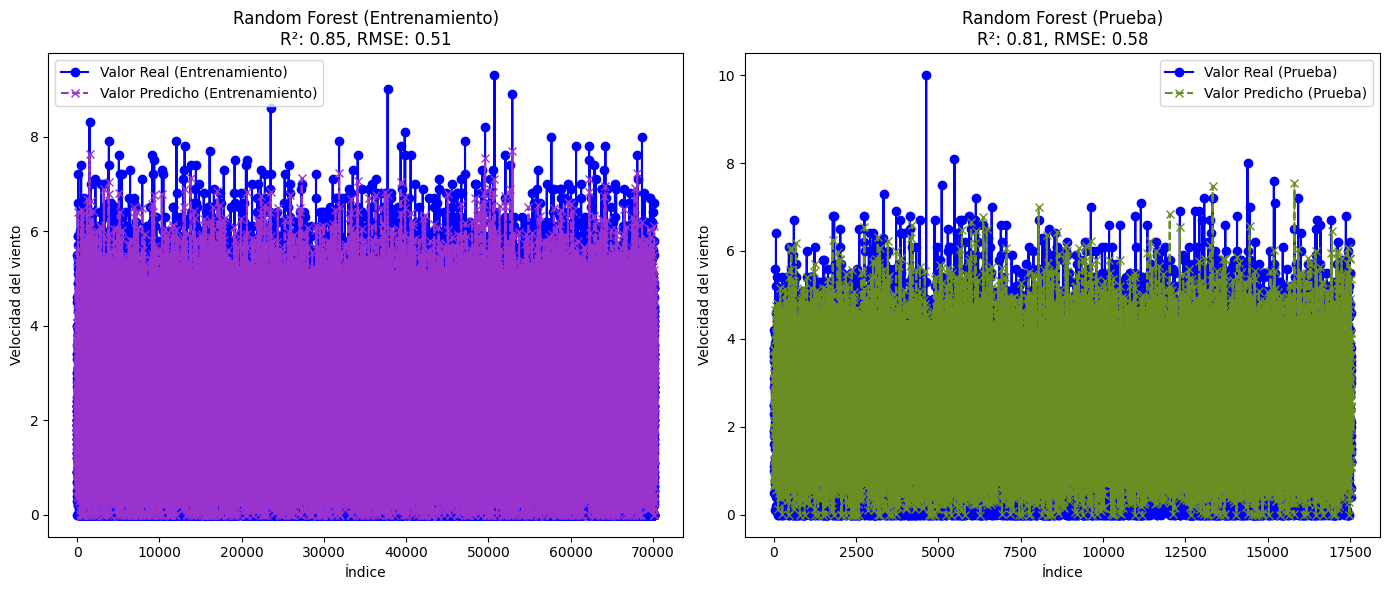

In [25]:
plt.figure(figsize=(14, 6))

ypredtrainranfor = bestranfor.predict(X_train)
rmsetrainranfor = mean_squared_error(y_train, ypredtrainranfor, squared=False)
mapetrainranfor = MAPE(y_train, ypredtrainranfor)
r2trainranfor = r2_score(y_train, ypredtrainranfor)

# Gráfico para el conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(range(len(y_train)), y_train, label="Valor Real (Entrenamiento)", color='blue', linestyle='-', marker='o')
plt.plot(range(len(ypredtrainranfor)), ypredtrainranfor, label="Valor Predicho (Entrenamiento)", color='#9A32CD', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"Random Forest (Entrenamiento)\nR²: {r2trainranfor:.2f}, RMSE: {rmsetrainranfor:.2f}")
plt.legend()

# Gráfico para el conjunto de prueba
plt.subplot(1, 2, 2)
plt.plot(range(len(y_test)), y_test, label="Valor Real (Prueba)", color='blue', linestyle='-', marker='o')
plt.plot(range(len(ypredranfor)), ypredranfor, label="Valor Predicho (Prueba)", color='#6B8E23', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"Random Forest (Prueba)\nR²: {r2ranfor:.2f}, RMSE: {rmseranfor:.2f}")
plt.legend()

# Mostrar gráfico
plt.tight_layout()
plt.show()

In [26]:
import pickle
with open("C:/Users/valcd/OneDrive/Escritorio/MachinelearningUN/ranfordata.pkl", 'wb') as f:
    pickle.dump(bestranfor, f)
    pickle.dump(y_train, f)
    pickle.dump(ypredtrainranfor, f)
    pickle.dump(y_test, f)
    pickle.dump(ypredranfor, f)
    pickle.dump(cuadro5, f)

### **XGBOOST**

In [27]:
xgboost = XGBRegressor(random_state=21)

xgboost_paramgrid = {'n_estimators': Integer(10, 100),'max_depth': Integer(5, 20),'learning_rate': (0.01, 0.3, 'uniform')}

xgboost_bayessearch = BayesSearchCV(estimator=xgboost,search_spaces=xgboost_paramgrid,n_iter=30, cv=5,random_state=21,verbose=0,n_jobs=-1)

xgboost_bayessearch.fit(X_train, y_train)

bestxgboost = xgboost_bayessearch.best_estimator_

ypredxgboost = bestxgboost.predict(X_test)

msexgboost = mean_squared_error(y_test, ypredxgboost)
rmsexgboost = np.sqrt(msexgboost)
mapexgboost = MAPE(y_test, ypredxgboost)
maexgboost = mean_absolute_error(y_test, ypredxgboost)
r2xgboost = r2_score(y_test, ypredxgboost)
ljungboxxgboost, jarquebarexgboost = residuos(y_test, ypredxgboost)
bestparamsxgboost = xgboost_bayessearch.best_params_

In [28]:
valoresxgboost = {'Modelo': ['XGBOOST'],'MSE': [msexgboost],'RMSE': [rmsexgboost],'MAPE': [mapexgboost],'MAE': [maexgboost],'R2': [r2xgboost],'Ljung-Box p-value': [ljungboxxgboost],'Jarque-Bera p-value': [jarquebarexgboost],'Hiperparámetros': [bestparamsxgboost]}
cuadro6 = pd.DataFrame(valoresxgboost)
cuadro6

,Modelo,MSE,RMSE,MAPE,MAE,R2,Ljung-Box p-value,Jarque-Bera p-value,Hiperparámetros
0,XGBOOST,0.328569,0.573209,30.423383,0.433031,0.809432,0.41422,0.0,"{'learning_rate': 0.1541879759174186, 'max_dep..."


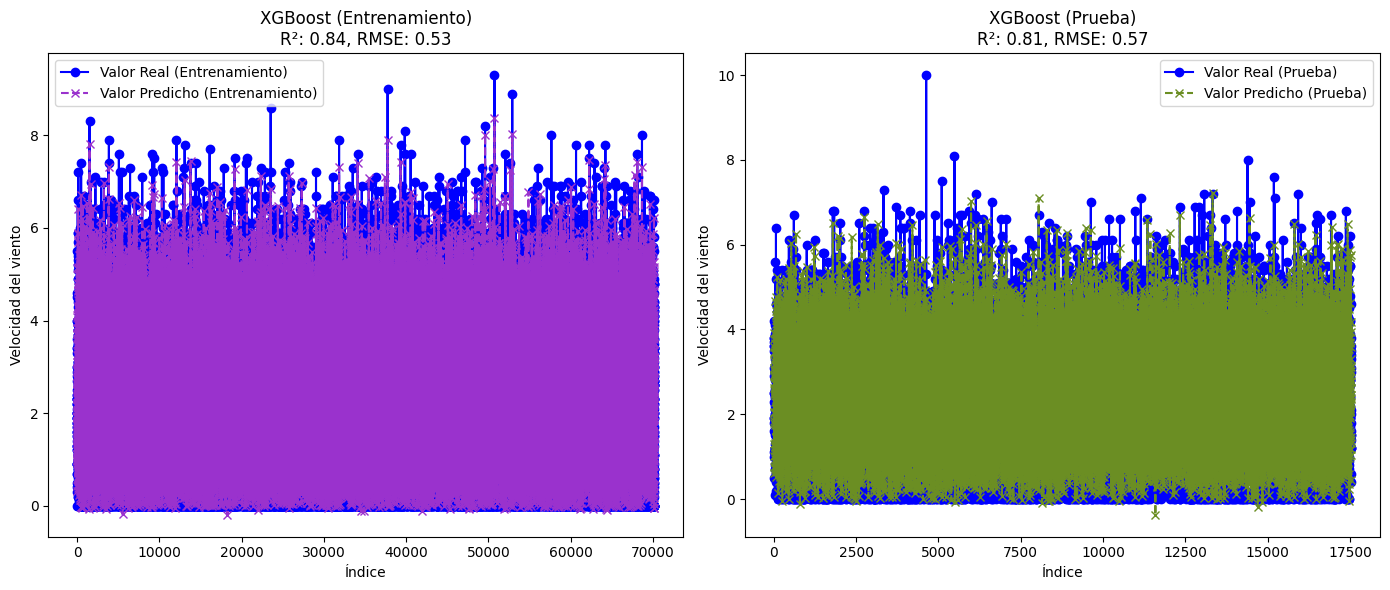

In [29]:
plt.figure(figsize=(14, 6))

ypredtrainxgboost = bestxgboost.predict(X_train)
rmsetrainxgboost = mean_squared_error(y_train, ypredtrainxgboost, squared=False)
mapetrainxgboost = MAPE(y_train, ypredtrainxgboost)
r2trainxgboost = r2_score(y_train, ypredtrainxgboost)

# Gráfico para el conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(range(len(y_train)), y_train, label="Valor Real (Entrenamiento)", color='blue', linestyle='-', marker='o')
plt.plot(range(len(ypredtrainxgboost)), ypredtrainxgboost, label="Valor Predicho (Entrenamiento)", color='#9A32CD', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"XGBoost (Entrenamiento)\nR²: {r2trainxgboost:.2f}, RMSE: {rmsetrainxgboost:.2f}")
plt.legend()

# Gráfico para el conjunto de prueba
plt.subplot(1, 2, 2)
plt.plot(range(len(y_test)), y_test, label="Valor Real (Prueba)", color='blue', linestyle='-', marker='o')
plt.plot(range(len(ypredxgboost)), ypredxgboost, label="Valor Predicho (Prueba)", color='#6B8E23', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"XGBoost (Prueba)\nR²: {r2xgboost:.2f}, RMSE: {rmsexgboost:.2f}")
plt.legend()

# Mostrar gráfico
plt.tight_layout()
plt.show()

In [30]:
import pickle
with open("C:/Users/valcd/OneDrive/Escritorio/MachinelearningUN/xgboostdata.pkl", 'wb') as f:
    pickle.dump(bestxgboost, f)
    pickle.dump(y_train, f)
    pickle.dump(ypredtrainxgboost, f)
    pickle.dump(y_test, f)
    pickle.dump(ypredxgboost, f)
    pickle.dump(cuadro6, f)

### **SVR**

In [ ]:
svr = SVR()

svr_paramgrid = {"C": (0.1, 1), "kernel": ["rbf"], "gamma": ["scale", "auto"]}

svr_bayessearch = BayesSearchCV(estimator=svr, search_spaces=svr_paramgrid,n_iter=20,cv=5,random_state=21,verbose=0, n_jobs=-1)

svr_bayessearch.fit(X_train, y_train)

bestsvr = svr_bayessearch.best_estimator_
ypredsvr = bestsvr.predict(X_test)

msesvr = mean_squared_error(y_test, ypredsvr)
rmsesvr = np.sqrt(msesvr)
mapesvr =MAPE(y_test,ypredsvr)
maesvr = mean_absolute_error(y_test, ypredsvr)
r2svr = r2_score(y_test, ypredsvr)
ljungboxsvr, jarquebaresvr = residuos(y_test, ypredsvr) 
bestparamssvr = svr_bayessearch.best_params_


In [ ]:
valoressvr = {'Modelo': ['SVR'],'MSE': [msesvr],'RMSE': [rmsesvr],'MAPE': [mapesvr],'MAE': [maesvr],'R2': [r2svr],'Ljung-Box p-value': [ljungboxsvr],'Jarque-Bera p-value': [jarquebaresvr],'Hiperparámetros': [bestparamssvr]}
cuadro7 = pd.DataFrame(valoressvr)
cuadro7

In [ ]:
plt.figure(figsize=(14, 6))

ypredtrainsvr = bestsvr.predict(X_train)
rmsetrainsvr = mean_squared_error(y_train, ypredtrainsvr, squared=False)
mapetrainsvr = MAPE(y_train, ypredtrainsvr)
r2trainsvr = r2_score(y_train, ypredtrainsvr)

# Gráfico para el conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(range(len(y_train)), y_train, label="Valor Real (Entrenamiento)", color='blue', linestyle='-', marker='o')
plt.plot(range(len(ypredtrainsvr)), ypredtrainsvr, label="Valor Predicho (Entrenamiento)", color='#9A32CD', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"SVR (Entrenamiento)\nR²: {r2trainsvr:.2f}, RMSE: {rmsetrainsvr:.2f}")
plt.legend()

# Gráfico para el conjunto de prueba
plt.subplot(1, 2, 2)
plt.plot(range(len(y_test)), y_test, label="Valor Real (Prueba)", color='blue', linestyle='-', marker='o')
plt.plot(range(len(ypredsvr)), ypredsvr, label="Valor Predicho (Prueba)", color='#6B8E23', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"SVR (Prueba)\nR²: {r2svr:.2f}, RMSE: {rmsesvr:.2f}")
plt.legend()

# Mostrar gráfico
plt.tight_layout()
plt.show()

In [ ]:
import pickle
with open("C:/Users/valcd/OneDrive/Escritorio/MachinelearningUN/svrdata.pkl", 'wb') as f:
    pickle.dump(bestsvr, f)
    pickle.dump(y_train, f)
    pickle.dump(ypredtrainsvr, f)
    pickle.dump(y_test, f)
    pickle.dump(ypredsvr, f)
    pickle.dump(cuadro7, f)

### **REGRESIÓN LINEAL**

In [ ]:
reglin = LinearRegression()

reglin.fit(X_train, y_train)

ypredreglin = reglin.predict(X_test)

msereglin = mean_squared_error(y_test, ypredreglin)
rmsereglin = np.sqrt(msereglin)
mapereglin =MAPE(y_test,ypredreglin)
maereglin = mean_absolute_error(y_test, ypredreglin)
r2reglin = r2_score(y_test, ypredreglin)
ljungboxreglin, jarqueberareglin = residuos(y_test, ypredreglin) 
bestparamsreglin = "None"
       

In [ ]:
valoresreglin = {'Modelo': ['REG. LINEAL'],'MSE': [msereglin],'RMSE': [rmsereglin],'MAPE': [mapereglin],'MAE': [maereglin],'R2': [r2reglin],'Ljung-Box p-value': [ljungboxreglin],'Jarque-Bera p-value': [jarqueberareglin],'Hiperparámetros': [bestparamsreglin]}
cuadro8 = pd.DataFrame(valoresreglin)
cuadro8

,Modelo,MSE,RMSE,MAPE,MAE,R2,Ljung-Box p-value,Jarque-Bera p-value,Hiperparámetros
0,REG. LINEAL,0.375793,0.613019,32.34396,0.460758,0.782042,0.539342,0.0,None


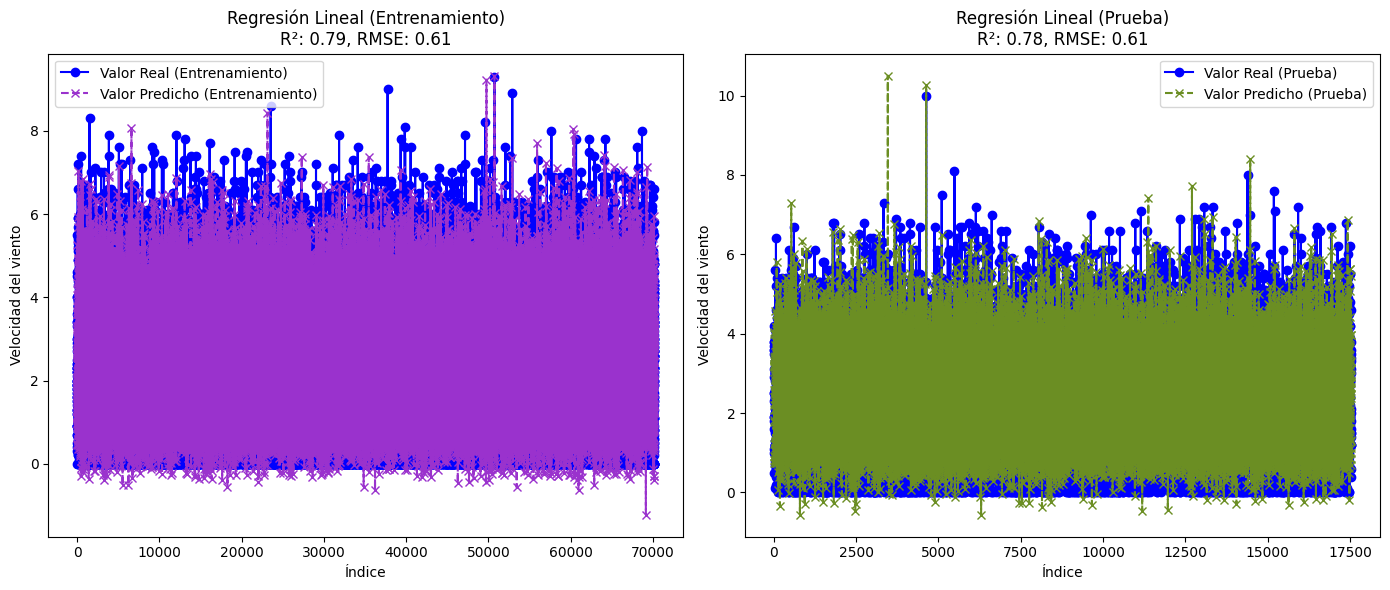

In [ ]:
plt.figure(figsize=(14, 6))

ypredtrainreglin = reglin.predict(X_train)
rmsetrainreglin = mean_squared_error(y_train, ypredtrainreglin, squared=False)
mapetrainreglin = MAPE(y_train, ypredtrainreglin)
r2trainreglin = r2_score(y_train, ypredtrainreglin)

# Gráfico para el conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(range(len(y_train)), y_train, label="Valor Real (Entrenamiento)", color='blue', linestyle='-', marker='o')
plt.plot(range(len(ypredtrainreglin)), ypredtrainreglin, label="Valor Predicho (Entrenamiento)", color='#9A32CD', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"Regresión Lineal (Entrenamiento)\nR²: {r2trainreglin:.2f}, RMSE: {rmsetrainreglin:.2f}")
plt.legend()

# Gráfico para el conjunto de prueba
plt.subplot(1, 2, 2)
plt.plot(range(len(y_test)), y_test, label="Valor Real (Prueba)", color='blue', linestyle='-', marker='o')
plt.plot(range(len(ypredreglin)), ypredreglin, label="Valor Predicho (Prueba)", color='#6B8E23', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"Regresión Lineal (Prueba)\nR²: {r2reglin:.2f}, RMSE: {rmsereglin:.2f}")
plt.legend()

# Mostrar gráfico
plt.tight_layout()
plt.show()

In [ ]:
import pickle
with open("C:/Users/valcd/OneDrive/Escritorio/MachinelearningUN/reglindata.pkl", 'wb') as f:
    pickle.dump(reglin, f)
    pickle.dump(y_train, f)
    pickle.dump(ypredtrainreglin, f)
    pickle.dump(y_test, f)
    pickle.dump(ypredreglin, f)
    pickle.dump(cuadro8, f)